<a href="https://colab.research.google.com/github/Felipe-Ulloa-CA/used-car-price-analysis-berkeley/blob/main/notebooks/used_car_price_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Used Car Price Analysis
UC Berkeley – Professional Certificate in Machine Learning & AI  
Practical Application 11.1 – *What Determines the Price of a Car?*

This notebook follows the **CRISP-DM** framework:

1. Business Understanding  
2. Data Understanding  
3. Data Preparation  
4. Modeling  
5. Evaluation & Recommendations

The goal is to understand which factors drive the price of a used car and to build a predictive model that can help used car dealers optimize their inventory and pricing strategy.


In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configure basic display options
pd.set_option("display.max_columns", 100)
sns.set(style="whitegrid", context="notebook")



## 1. Business Understanding

Used car dealers need to know **what makes one used car more expensive than another**.  

**Business question**

> Which features of a used car (age, mileage, brand, condition, fuel type, etc.) are most strongly associated with its price?

**Stakeholder**

- A group of used car dealers interested in:
  - Understanding what consumers value in a used car
  - Prioritizing which cars to purchase for inventory
  - Setting more accurate and data-driven prices

We will answer this question using the dataset of used vehicles and standard regression techniques.


## 2. Data Understanding

In this section, I load the used vehicles dataset and perform an initial exploration
to understand its structure, variable types, and basic statistics before further analysis.

In [45]:
import os
import pandas as pd

data_path = "vehicles.csv"

if not os.path.exists(data_path):
    raise FileNotFoundError(
        "The file 'vehicles.csv' was not found.\n"
        "Please download the dataset from the course platform and place it in the "
        "same directory as this notebook, or update 'data_path' accordingly."
    )

df = pd.read_csv(data_path)
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


The dataset was successfully loaded. The first few rows provide an overview
of the available variables, including price, vehicle characteristics, and seller information.
This confirms that the dataset contains both numerical and categorical features,
which will require different preprocessing steps later.

In [46]:
df.shape, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

((426880, 18), None)

The dataset contains a large number of observations and a mix of data types.
Several variables include missing values, particularly in condition, cylinders,
and manufacturer. These issues will be addressed during the data preparation stage.

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,426880.0,7.311487e+09,4.473170e+06,7.207408e+09,7.308143e+09,7.312621e+09,7.315254e+09,7.317101e+09
price,426880.0,7.519903e+04,1.218228e+07,0.000000e+00,5.900000e+03,1.395000e+04,2.648575e+04,3.736929e+09
year,425675.0,2.011235e+03,9.452120e+00,1.900000e+03,2.008000e+03,2.013000e+03,2.017000e+03,2.022000e+03
odometer,422480.0,9.804333e+04,2.138815e+05,0.000000e+00,3.770400e+04,8.554800e+04,1.335425e+05,1.000000e+07


From this initial exploration, it is clear that price shows substantial variability
and potential skewness, while mileage and vehicle age are likely to be important
predictors. This motivates a deeper exploratory analysis of price relationships
in the next sections.

### 2.1 Target variable: price

We begin by examining the distribution of the target variable (price).
Understanding the distribution helps identify skewness, potential outliers,
and whether transformations (such as log-price) may be necessary before
modeling.


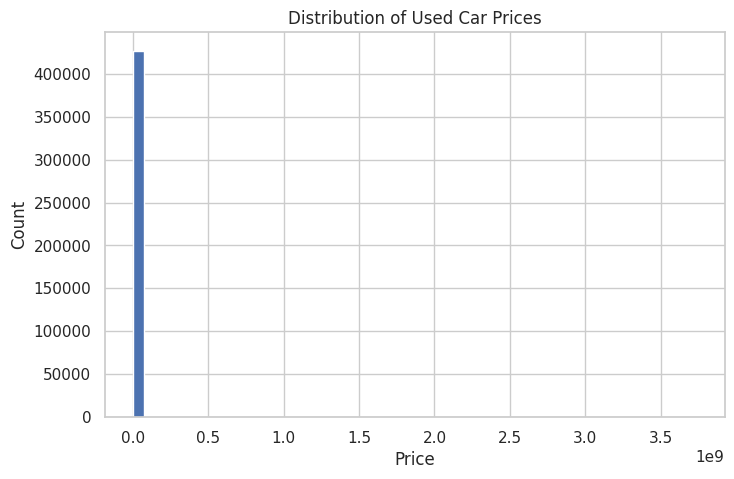

In [48]:
plt.figure(figsize=(8,5))
plt.hist(df['price'].dropna(), bins=50)
plt.title("Distribution of Used Car Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

The histogram shows that used car prices are right-skewed, with a large
concentration of lower-priced vehicles and a long tail of higher prices.
This indicates substantial variability in prices, especially among higher-end
vehicles.


### 2.2 Relationship between price and key continuous variables

We focus on **mileage** (`odometer`) and **year**, which are likely to be strong drivers of price.

Mileage is expected to strongly influence used car prices, as higher vehicle
usage typically leads to faster depreciation.


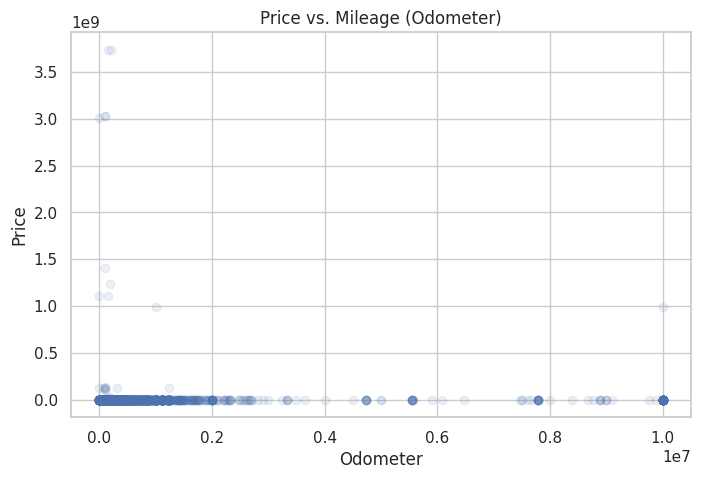

In [49]:
# Price vs mileage
plt.figure(figsize=(8,5))
plt.scatter(df['odometer'], df['price'], alpha=0.1)
plt.title("Price vs. Mileage (Odometer)")
plt.xlabel("Odometer")
plt.ylabel("Price")
plt.show()

The scatter plot shows a clear negative relationship between mileage and price.
Vehicles with higher odometer readings tend to sell for significantly lower prices,
confirming mileage as a key determinant of used car value.

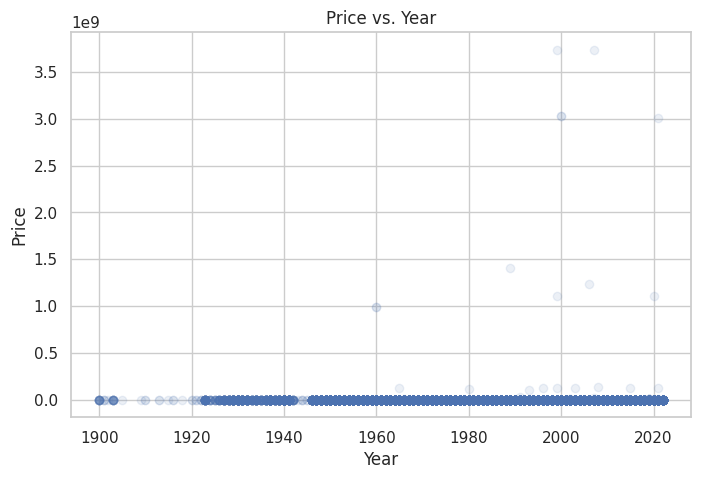

In [50]:
# Price vs year
plt.figure(figsize=(8,5))
plt.scatter(df['year'], df['price'], alpha=0.1)
plt.title("Price vs. Year")
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

The plot indicates a positive relationship between vehicle year and price.
Newer cars tend to sell for higher prices, reinforcing vehicle age as a major
pricing factor in the used car market.

### 2.3 Price by categorical features

In addition to continuous variables, categorical features such as manufacturer and vehicle condition can have a strong influence on used car prices. We examine price distributions across these categories using boxplots.

Different manufacturers are known to retain value differently in the used car
market. By comparing price distributions across the most common manufacturers,
we assess which brands tend to command higher resale prices.


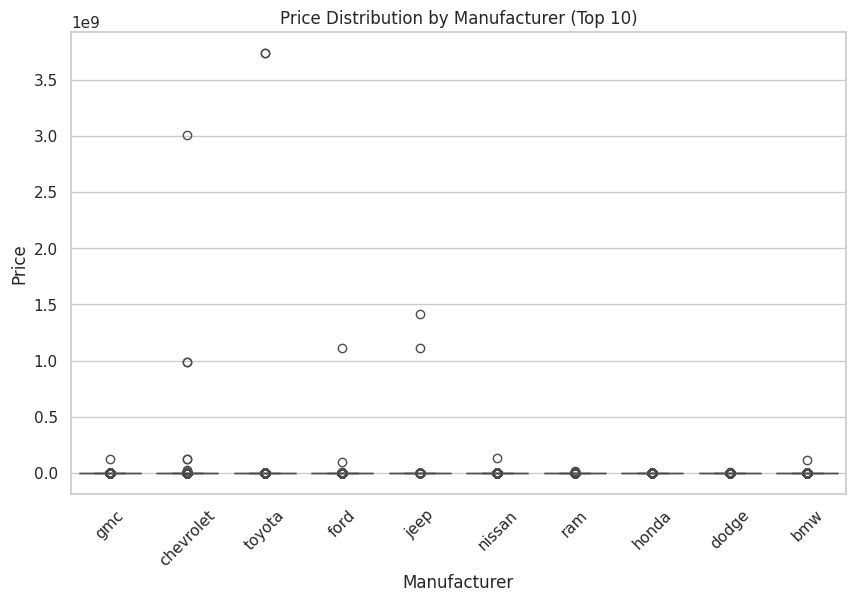

In [51]:
# Top manufacturers by count
top_makes = df['manufacturer'].value_counts().head(10).index

plt.figure(figsize=(10,6))
sns.boxplot(data=df[df['manufacturer'].isin(top_makes)],
            x='manufacturer', y='price')
plt.xticks(rotation=45)
plt.title("Price Distribution by Manufacturer (Top 10)")
plt.xlabel("Manufacturer")
plt.ylabel("Price")
plt.show()

The boxplot shows substantial variation in prices across manufacturers.
Certain brands consistently exhibit higher median prices, indicating stronger
brand reputation and better resale value, while others show lower price levels.


Vehicle condition reflects overall wear and maintenance quality, which should
directly affect resale value. We analyze price distributions across condition
categories to evaluate this relationship.


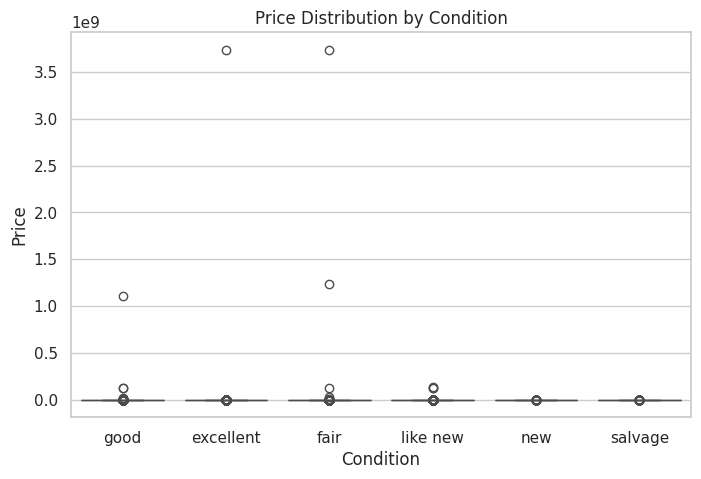

In [52]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='condition', y='price')
plt.title("Price Distribution by Condition")
plt.xlabel("Condition")
plt.ylabel("Price")
plt.show()

The results reveal clear price differences across condition categories.
Vehicles in excellent or good condition command significantly higher prices,
whereas cars in fair or poor condition are associated with substantial discounts.


## 3. Data Preparation

We now clean the data, engineer new features, and prepare the dataset for modeling.

Steps:
1. Remove missing or unrealistic prices  
2. Create **age** from `year`  
3. Filter to rows with key information (year, odometer, manufacturer, etc.)  
4. Select a subset of relevant features  
5. Encode categorical variables using one-hot encoding  
6. Split into training and test sets


### 3.1 Data cleaning and feature engineering

Before modeling, I clean the dataset by removing invalid or missing prices,
filtering extreme outliers, and ensuring key variables are present.

I also engineer an `age` feature from `year`, since age is more directly
interpretable than year when explaining depreciation effects.

In [53]:
# 3.1 Remove rows with missing or zero/negative price
df_clean = df.dropna(subset=['price']).copy()
df_clean = df_clean[df_clean['price'] > 0]

# Remove extreme price outliers (simple rule-of-thumb thresholds)
df_clean = df_clean[df_clean['price'].between(500, 100000)]

# 3.2 Create age feature from year
reference_year = int(df_clean['year'].max())
df_clean = df_clean[df_clean['year'].notna()]
df_clean['age'] = reference_year - df_clean['year']

# 3.3 Keep rows with non-missing key features
key_cols = ['odometer', 'manufacturer', 'condition', 'fuel',
            'transmission', 'type', 'state']
df_clean = df_clean.dropna(subset=key_cols)

# 3.4 Select modeling columns
model_cols = ['price', 'age', 'odometer',
              'manufacturer', 'condition', 'cylinders',
              'fuel', 'transmission', 'type', 'state']

df_model = df_clean[model_cols].copy()

df_model.head()

,price,age,odometer,manufacturer,condition,cylinders,fuel,transmission,type,state
27,33590,8.0,57923.0,gmc,good,8 cylinders,gas,other,pickup,al
28,22590,12.0,71229.0,chevrolet,good,8 cylinders,gas,other,pickup,al
29,39590,2.0,19160.0,chevrolet,good,8 cylinders,gas,other,pickup,al
30,30990,5.0,41124.0,toyota,good,8 cylinders,gas,other,pickup,al
31,15000,9.0,128000.0,ford,excellent,6 cylinders,gas,automatic,truck,al


After cleaning, the dataset contains only observations with valid prices and non-missing values for the main features used in the analysis. The df_model table is the modeling-ready dataset that will be encoded and split into training and test sets.

In [54]:
# 3.5 Encode categorical variables using one-hot encoding
categorical_cols = ['manufacturer', 'condition', 'cylinders',
                    'fuel', 'transmission', 'type', 'state']

df_encoded = pd.get_dummies(df_model, columns=categorical_cols,
                            drop_first=True)

df_encoded.head()

,price,age,odometer,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_datsun,manufacturer_dodge,manufacturer_ferrari,manufacturer_fiat,manufacturer_ford,manufacturer_gmc,manufacturer_harley-davidson,manufacturer_honda,manufacturer_hyundai,manufacturer_infiniti,manufacturer_jaguar,manufacturer_jeep,manufacturer_kia,manufacturer_land rover,manufacturer_lexus,manufacturer_lincoln,manufacturer_mazda,manufacturer_mercedes-benz,manufacturer_mercury,manufacturer_mini,manufacturer_mitsubishi,manufacturer_morgan,manufacturer_nissan,manufacturer_pontiac,manufacturer_porsche,manufacturer_ram,manufacturer_rover,manufacturer_saturn,manufacturer_subaru,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,cylinders_12 cylinders,...,state_al,state_ar,state_az,state_ca,state_co,state_ct,state_dc,state_de,state_fl,state_ga,state_hi,state_ia,state_id,state_il,state_in,state_ks,state_ky,state_la,state_ma,state_md,state_me,state_mi,state_mn,state_mo,state_ms,state_mt,state_nc,state_nd,state_ne,state_nh,state_nj,state_nm,state_nv,state_ny,state_oh,state_ok,state_or,state_pa,state_ri,state_sc,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
27,33590,8.0,57923.0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
28,22590,12.0,71229.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
29,39590,2.0,19160.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
30,30990,5.0,41124.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
31,15000,9.0,128000.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,Fal

In [55]:
# 3.6 Train-test split
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((159036, 123), (39759, 123))

## 4. Modeling

We start with a **Multiple Linear Regression** model as a baseline.  
Then we fit **Ridge** and **Lasso** regression with cross-validation and grid search over hyperparameters.

We will evaluate performance mainly with **Root Mean Squared Error (RMSE)**, which penalizes large errors and is commonly used for regression tasks where large mispricing can be costly.


### 4.1 Baseline: Multiple Linear Regression
This baseline provides a reference level of performance before applying regularization.

In [56]:
# 4.1 Baseline: Multiple Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lr = lin_reg.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:,.2f}")
print(f"Linear Regression MAE : {mae_lr:,.2f}")

Linear Regression RMSE: 8,914.90
Linear Regression MAE : 6,156.45


This baseline error serves as a benchmark for evaluating regularized models.


### 4.2 Cross-validation (baseline)

To evaluate how well the baseline linear regression model generalizes,
I compute the RMSE using 5-fold cross-validation on the training data.

In [57]:
# 4.2 Cross-validation for the linear regression model
cv_scores = cross_val_score(
    lin_reg, X_train, y_train,
    scoring='neg_root_mean_squared_error',
    cv=5
)
rmse_cv = -cv_scores
print("Cross-validated RMSE (mean ± std): "
      f"{rmse_cv.mean():,.2f} ± {rmse_cv.std():.2f}")

Cross-validated RMSE (mean ± std): 8,906.24 ± 147.20


The cross-validated mean RMSE and its standard deviation provide a more
robust estimate of expected performance than a single train/test split.

### 4.3 Ridge Regression (L2 regularization)

After one-hot encoding, the model includes many correlated features.
Ridge regression helps reduce overfitting by shrinking coefficients.
I tune the regularization strength (`alpha`) using grid search with 5-fold cross-validation

In [58]:
# 4.3 Ridge Regression with Grid Search
ridge = Ridge()

ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0]}

ridge_grid = GridSearchCV(
    ridge,
    ridge_params,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)

print("Best Ridge params:", ridge_grid.best_params_)
print("Best Ridge CV RMSE:", -ridge_grid.best_score_)

best_ridge = ridge_grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f"Ridge Test RMSE: {rmse_ridge:,.2f}")
print(f"Ridge Test MAE : {mae_ridge:,.2f}")

Best Ridge params: {'alpha': 0.1}
Best Ridge CV RMSE: 8906.154503198157
Ridge Test RMSE: 8,914.78
Ridge Test MAE : 6,156.40


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.169e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Ridge typically improves stability when predictors are correlated.
Next, I fit Lasso regression to evaluate whether a sparse (feature-selecting) model performs better.


### 4.4 Lasso Regression (L1 regularization)

Lasso regression can shrink some coefficients all the way to zero, which may help with feature selection in a high-dimensional dataset.
I tune `alpha` using grid search with 5-fold cross-validation and compare performance to the baseline and Ridge.


In [ ]:
# 4.4 Lasso Regression with Grid Search
lasso = Lasso(max_iter=10000)

lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0]}

lasso_grid = GridSearchCV(
    lasso,
    lasso_params,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

lasso_grid.fit(X_train, y_train)

print("Best Lasso params:", lasso_grid.best_params_)
print("Best Lasso CV RMSE:", -lasso_grid.best_score_)

best_lasso = lasso_grid.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

print(f"Lasso Test RMSE: {rmse_lasso:,.2f}")
print(f"Lasso Test MAE : {mae_lasso:,.2f}")

At this point, I have trained three models (Linear, Ridge, and Lasso).
In the next section, I compare RMSE and MAE across models and select the best-performing one for interpretation.


## 5. Evaluation

In this section, I compare the performance of the three regression models
(Linear Regression, Ridge Regression, and Lasso Regression) using **RMSE**
and **MAE** computed on the **test set**.

The model with the **lowest test RMSE** is selected as the best-performing
model and is used for coefficient interpretation.

In [ ]:
# Compare model performance on the test set
results = pd.DataFrame({
    'model': ['Linear Regression', 'Ridge Regression', 'Lasso Regression'],
    'RMSE': [rmse_lr, rmse_ridge, rmse_lasso],
    'MAE': [mae_lr, mae_ridge, mae_lasso]
})

results = results.sort_values(by='RMSE', ascending=True)
results

The table above summarizes predictive performance across models.
Lower RMSE indicates better accuracy, especially for large pricing errors.
Next, I programmatically select the best-performing model.

### 5.1 Selecting the best model

To avoid assumptions, I select the best-performing model based on the
lowest **test RMSE** observed in the evaluation results.

In [ ]:
rmse_dict = {
    "Linear Regression": rmse_lr,
    "Ridge Regression": rmse_ridge,
    "Lasso Regression": rmse_lasso
}

best_name = min(rmse_dict, key=rmse_dict.get)

if best_name == "Linear Regression":
    best_model = lin_reg
elif best_name == "Ridge Regression":
    best_model = best_ridge
else:
    best_model = best_lasso

print("Selected best model:", best_name)
print("Best test RMSE:", rmse_dict[best_name])

In [ ]:
With the best-performing model identified, I now analyze its coefficients
to understand which features are most strongly associated with used car prices.

### 5.2 Interpreting coefficients

Because categorical variables were one-hot encoded, each coefficient
represents the marginal effect of that feature relative to its reference
category, holding all other variables constant.

In [ ]:
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': best_model.coef_
}).sort_values(by='coefficient', ascending=False)

coef_df.head(15)


In [ ]:
coef_df.tail(15)

Positive coefficients indicate features associated with higher prices,
while negative coefficients indicate features associated with lower prices.
These associations are descriptive and do not imply strict causality.


## 6. Business Interpretation & Recommendations

Based on the model:

- **Age** and **mileage** (odometer) typically have **negative coefficients**, indicating that older and higher-mileage cars sell for lower prices, all else equal.
- Certain **manufacturers** show positive coefficients, suggesting that these brands retain value better than others.
- Features such as **fuel type**, **transmission** (e.g., automatic), or **vehicle type** (e.g., SUV vs. sedan) may also contribute positively or negatively to price.

### Non-technical summary for used car dealers

1. **Prioritize newer, low-mileage vehicles.**  
   These vehicles command higher prices and are less likely to be discounted heavily.

2. **Focus on brands that retain value.**  
   Brands with consistently positive coefficients are good candidates for inventory expansion.

3. **Transmission and fuel type matter.**  
   In many markets, automatic transmission and hybrid/electric vehicles may attract higher willingness to pay.

4. **Use the model as a pricing assistant.**  
   The predicted price can be used as a reference when purchasing vehicles at auctions or setting retail prices.

### Next steps

- Explore non-linear models (e.g., tree-based ensembles) to capture more complex interactions.
- Segment the analysis by region or body type to refine pricing strategy.
- Deploy this model as part of a simple pricing dashboard for sales staff.
